# Calculate simulated IMU features

## 1) From global segment angles

In [4]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import LocomotionAnalysisTools as lat

In [22]:
# data
#dev_file = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Subject1/Session4_copy_Proc_GMC/Subj1 - Rec1 - Normal level walking - Rep1 - GloAng.csv"
dev_file = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Subject1/Session4_copy_Proc_GMC/Subj1 - Rec1 - Circular walking (diam 2m)(CW) - Rep1 - GloAng.csv"
check_file = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Subject1/Session4_copy_Proc_GMC/Subj1 - Rec1 - Normal level walking - Rep2 - GloAng.csv"

df = pd.read_csv(dev_file)
df_check = pd.read_csv(check_file)

cols_R = ["R_Femur_RX", "R_Femur_RY", "R_Femur_RZ"]
cols_T = ["R_Femur_TX", "R_Femur_TY", "R_Femur_TZ"]
seq = "XYZ"

rot_vec = df[cols_R].to_numpy()
rot_vec = rot_vec * (np.pi/180) # to radians
translations = df[cols_T].to_numpy()
translations = translations * 0.001 # to meters

rot_vec_check = df_check[cols_R].to_numpy()
rot_vec_check = rot_vec_check * (np.pi/180)
translations_check = df_check[cols_T].to_numpy()
translations_check = translations_check * 0.001

In [7]:
def get_simulated_IMU_measurements(segment_orientation_position, f_sample=100, seq="XYZ"):
    # Restructure
    rot_vecs = segment_orientation_position[:, 0:3] # in radians
    translations = segment_orientation_position[:, 3:6] # in meters

    # Change orientation representation, rotation vector to rotation matrices
    n_pts = np.shape(rot_vecs)[0]
    rot_matrices = np.zeros((n_pts, 3, 3))
    inv_rot_matrices = np.zeros((n_pts, 3, 3))

    for i in np.arange(n_pts):
        rotation = Rotation.from_rotvec(rot_vecs[i, :])
        rot_matrices[i, :, :] = rotation.as_matrix()
        inv_rot_matrices[i, :, :] = np.linalg.inv(rot_matrices[i, :, :])

    # Calculate rotational velocity and linear acceleration a measured from the segment frame of reference
    delta_rot_matrices = np.zeros((n_pts-1, 3, 3))
    delta_euler_angles = np.zeros((n_pts-1, 3))
    accelerations = np.diff(translations, n=2, axis=0)

    for i in np.arange(n_pts-2):
        delta_rot_matrices[i, :, :] = np.matmul(rot_matrices[i+1, :, :], inv_rot_matrices[i, :, :])
        rotation = Rotation.from_matrix(delta_rot_matrices[i, :, :])
        delta_euler_angles[i, :] = np.matmul(inv_rot_matrices[i, :, :], rotation.as_euler(seq).reshape((-1, 1))).reshape((1, -1))
        accelerations[i, :] = np.matmul(inv_rot_matrices[i, :, :], accelerations[i, :].reshape((-1, 1))).reshape((1, -1))

    i = n_pts-2
    delta_rot_matrices[i, :, :] = np.matmul(rot_matrices[i+1, :, :], inv_rot_matrices[i, :, :])
    rotation = Rotation.from_matrix(delta_rot_matrices[i, :, :])
    delta_euler_angles[i, :] = np.matmul(inv_rot_matrices[i, :, :], rotation.as_euler(seq).reshape((-1, 1))).reshape((1, -1))

    delta_euler_angles *= f_sample
    accelerations *= f_sample**2
    
    return delta_euler_angles, accelerations

(5977, 132)
(5977, 6)
(5976, 3)
(5975, 3)


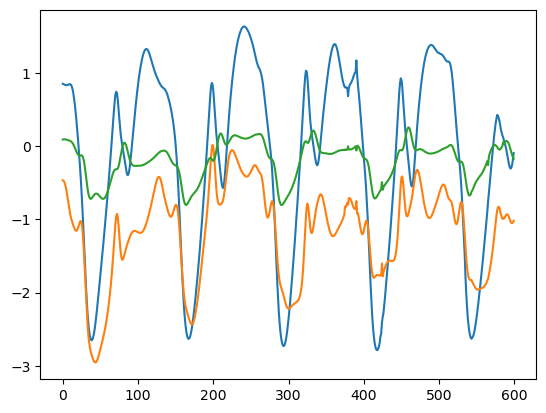

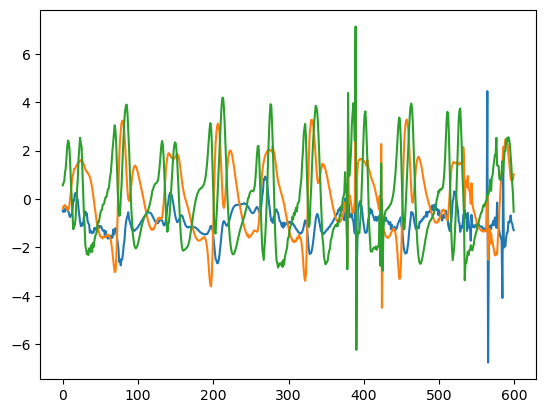

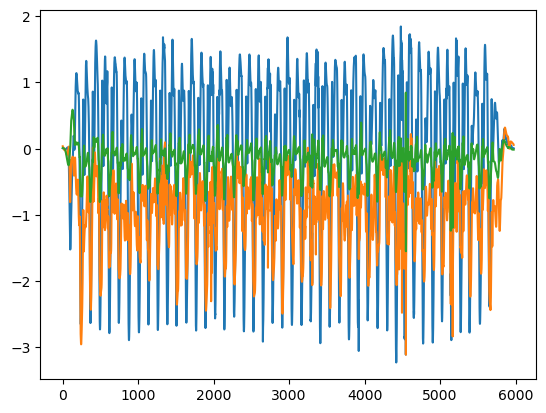

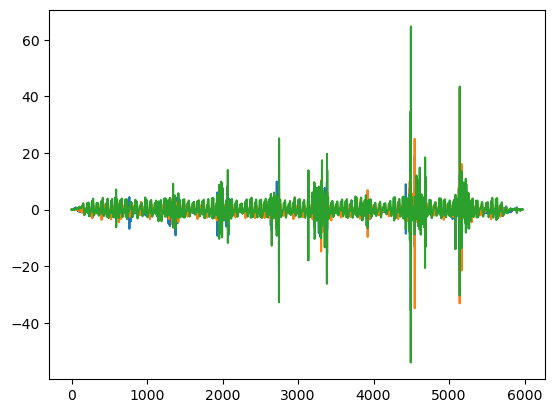

In [29]:
dev_file = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Subject1/Session4_copy_Proc_GMC/Subj1 - Rec1 - Circular walking (diam 2m)(CW) - Rep1 - GloAng.csv"
df = pd.read_csv(dev_file)

cols_RT = ["R_Femur_RX", "R_Femur_RY", "R_Femur_RZ", "R_Femur_TX", "R_Femur_TY", "R_Femur_TZ"]
segment_orientation_position = df[cols_RT].to_numpy()
segment_orientation_position[:, 0:3] = segment_orientation_position[:, 0:3] * (np.pi/180) # to radians
segment_orientation_position[:, 3:6] = segment_orientation_position[:, 3:6] * 0.001 # to meters

delta_euler_angles, accelerations = get_simulated_IMU_measurements(segment_orientation_position, f_sample=100, seq="XYZ")

print(df.shape)
print(np.shape(segment_orientation_position))
print(np.shape(delta_euler_angles))
print(np.shape(accelerations))

plt.figure()
plt.plot(delta_euler_angles[200:800, 0])
plt.plot(delta_euler_angles[200:800, 1])
plt.plot(delta_euler_angles[200:800, 2])
plt.show()

plt.figure()
plt.plot(accelerations[200:800, 0])
plt.plot(accelerations[200:800, 1])
plt.plot(accelerations[200:800, 2])
plt.show()

plt.figure()
plt.plot(delta_euler_angles[:, 0])
plt.plot(delta_euler_angles[:, 1])
plt.plot(delta_euler_angles[:, 2])
plt.show()

plt.figure()
plt.plot(accelerations[:, 0])
plt.plot(accelerations[:, 1])
plt.plot(accelerations[:, 2])
plt.show()

In [24]:
n_pts = np.shape(rot_vec)[0]
rot_matrices = np.zeros((n_pts, 3, 3))
x_axes = np.zeros((n_pts, 3))
y_axes = np.zeros((n_pts, 3))
z_axes = np.zeros((n_pts, 3))

n_pts_check = np.shape(rot_vec_check)[0]
rot_matrices_check = np.zeros((n_pts_check, 3, 3))

for i in np.arange(n_pts):
    rotation = Rotation.from_rotvec(rot_vec[i, :])
    rot_matrices[i, :, :] = rotation.as_matrix()
    x_axes[i, :] = rot_matrices[i, :, 0].reshape((1, -1))
    y_axes[i, :] = rot_matrices[i, :, 1].reshape((1, -1))
    z_axes[i, :] = rot_matrices[i, :, 2].reshape((1, -1))
    
for i in np.arange(n_pts_check):
    rotation_check = Rotation.from_rotvec(rot_vec_check[i, :])
    rot_matrices_check[i, :, :] = rotation_check.as_matrix()

In [26]:
%matplotlib qt

# visualise
ax = plt.figure().add_subplot(projection='3d')
ax.set_aspect("equal")

# origins
x = translations[:, 0]
y = translations[:, 1]
z = translations[:, 2]

# axes
ux = x_axes[:, 0]
vx = x_axes[:, 1]
wx = x_axes[:, 2]

uy = y_axes[:, 0]
vy = y_axes[:, 1]
wy = y_axes[:, 2]

uz = z_axes[:, 0]
vz = z_axes[:, 1]
wz = z_axes[:, 2]

# actual plot
ax.quiver(x, y, z, ux, vx, wx, length=0.1, normalize=True, color=(1, 0, 0))
ax.quiver(x, y, z, uy, vy, wy, length=0.1, normalize=True, color=(0, 1, 0))
ax.quiver(x, y, z, uz, vz, wz, length=0.1, normalize=True, color=(0, 0, 1))

# create cubic bounding box to simulate equal aspect ratio
max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')

plt.show()

In [40]:
# Calculate small rotations
delta_rot_matrices = np.zeros((n_pts-1, 3, 3))
delta_euler_angles = np.zeros((n_pts-1, 3))
accelerations = np.diff(translations, n=2, axis=0) * 10000

delta_rot_matrices_check = np.zeros((n_pts_check-1, 3, 3))
delta_euler_angles_check = np.zeros((n_pts_check-1, 3))

for i in np.arange(n_pts-2):
    delta_rot_matrices[i, :, :] = np.matmul(rot_matrices[i+1, :, :], np.linalg.inv(rot_matrices[i, :, :]))
    rotation = Rotation.from_matrix(delta_rot_matrices[i, :, :])
    delta_euler_angles[i, :] = np.matmul(np.linalg.inv(rot_matrices[i, :, :]), rotation.as_euler(seq).reshape((-1, 1))).reshape((1, -1))
    accelerations[i, :] = np.matmul(np.linalg.inv(rot_matrices[i, :, :]), accelerations[i, :].reshape((-1, 1))).reshape((1, -1))
    
for i in np.arange(n_pts_check-1):
    delta_rot_matrices_check[i, :, :] = np.matmul(rot_matrices_check[i+1, :, :], np.linalg.inv(rot_matrices_check[i, :, :]))
    rotation_check = Rotation.from_matrix(delta_rot_matrices_check[i, :, :])
    delta_euler_angles_check[i, :] = np.matmul(np.linalg.inv(rot_matrices_check[i, :, :]), rotation_check.as_euler(seq).reshape((-1, 1))).reshape((1, -1))

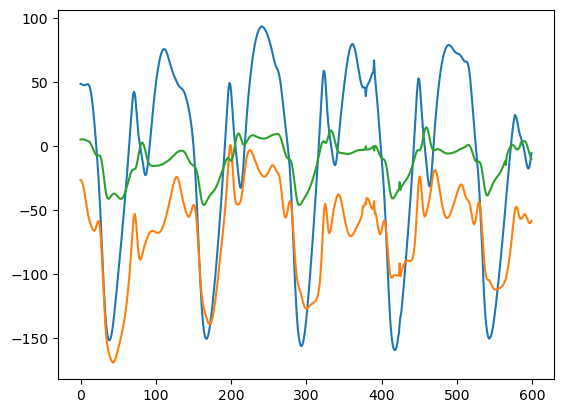

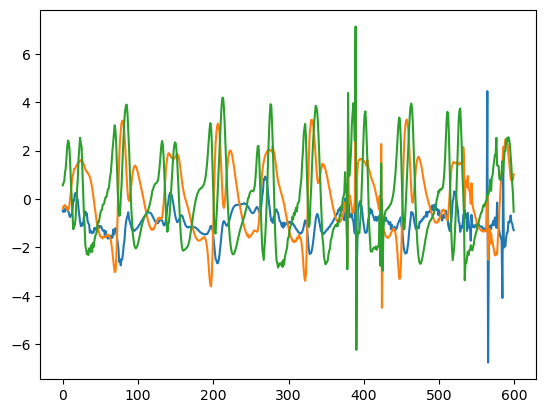

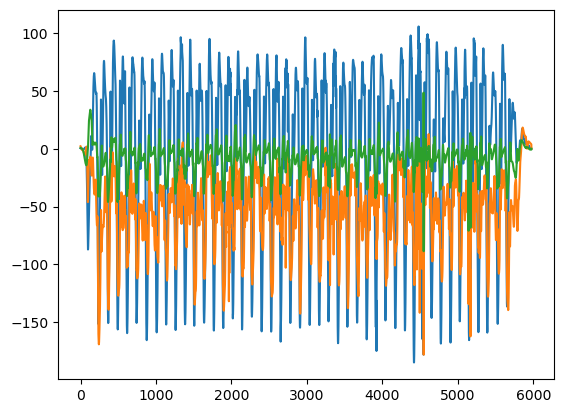

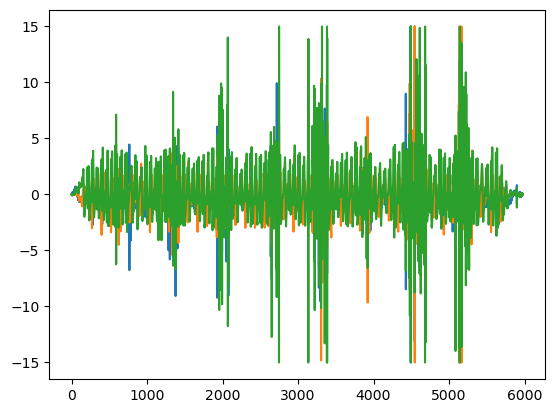

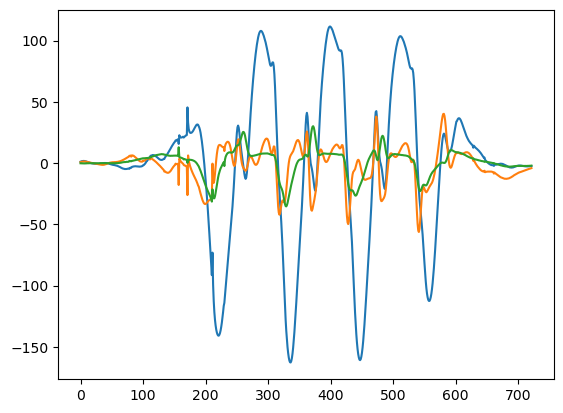

In [44]:
delta_euler_dgps = delta_euler_angles * 180 * 100 / np.pi
delta_euler_dgps_check = delta_euler_angles_check * 180 * 100 / np.pi

accelerations = np.where(accelerations < 15, accelerations, 15)
accelerations = np.where(accelerations > -15, accelerations, -15)

%matplotlib inline

plt.figure()
plt.plot(delta_euler_dgps[200:800, 0])
plt.plot(delta_euler_dgps[200:800, 1])
plt.plot(delta_euler_dgps[200:800, 2])
plt.show()

plt.figure()
plt.plot(accelerations[200:800, 0])
plt.plot(accelerations[200:800, 1])
plt.plot(accelerations[200:800, 2])
plt.show()

plt.figure()
plt.plot(delta_euler_dgps[:, 0])
plt.plot(delta_euler_dgps[:, 1])
plt.plot(delta_euler_dgps[:, 2])
plt.show()

plt.figure()
plt.plot(accelerations[:, 0])
plt.plot(accelerations[:, 1])
plt.plot(accelerations[:, 2])
plt.show()

plt.figure()
plt.plot(delta_euler_dgps_check[:, 0])
plt.plot(delta_euler_dgps_check[:, 1])
plt.plot(delta_euler_dgps_check[:, 2])
plt.show()

## 2) From marker data

In [11]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

In [13]:
# data
#dev_file = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Subject1/Session4_copy_Proc_GMC/Subj1 - Rec1 - Normal level walking - Rep1 - AllTraj.csv"
dev_file = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Subject1/Session4_copy_Proc_GMC/Subj1 - Rec1 - Circular walking (diam 2m)(CW) - Rep1 - AllTraj.csv"
df = pd.read_csv(dev_file)

In [15]:
df.columns

Index(['LASIX', 'LASIY', 'LASIZ', 'RASIX', 'RASIY', 'RASIZ', 'LPSIX', 'LPSIY',
       'LPSIZ', 'RPSIX', 'RPSIY', 'RPSIZ', 'LTHIX', 'LTHIY', 'LTHIZ', 'LKNEX',
       'LKNEY', 'LKNEZ', 'LTIBX', 'LTIBY', 'LTIBZ', 'LANKX', 'LANKY', 'LANKZ',
       'LHEEX', 'LHEEY', 'LHEEZ', 'LTOEX', 'LTOEY', 'LTOEZ', 'RTHIX', 'RTHIY',
       'RTHIZ', 'RKNEX', 'RKNEY', 'RKNEZ', 'RTIBX', 'RTIBY', 'RTIBZ', 'RANKX',
       'RANKY', 'RANKZ', 'RHEEX', 'RHEEY', 'RHEEZ', 'RTOEX', 'RTOEY', 'RTOEZ'],
      dtype='object')

In [17]:
RASI = df[["RASIX", "RASIY", "RASIZ"]].to_numpy()
RPSI = df[["RPSIX", "RPSIY", "RPSIZ"]].to_numpy()
RHIP = (RASI + RPSI)/2
RTHI = df[["RTHIX", "RTHIY", "RTHIZ"]].to_numpy()
RKNE = df[["RKNEX", "RKNEY", "RKNEZ"]].to_numpy()

In [19]:
z_axes = (RHIP - RKNE)
z_axes = z_axes / np.tile(np.linalg.norm(z_axes, axis=1).reshape((-1, 1)), (1, 3))

In [21]:
n_pts = np.shape(z_axes)[0]
y_axes = np.zeros((n_pts, 3))

for i in np.arange(n_pts):
    c_plane = np.dot(z_axes[i, :], RTHI[i, :])
    s_point = c_plane - np.dot(z_axes[i, :], RKNE[i, :])
    point = RKNE[i, :] + s_point*z_axes[i, :]
    y_axes[i, :] = RTHI[i, :] - point

y_axes = y_axes / np.tile(np.linalg.norm(y_axes, axis=1).reshape((-1, 1)), (1, 3))

In [23]:
x_axes = np.cross(y_axes, z_axes)

In [25]:
%matplotlib qt

# visualise
ax = plt.figure().add_subplot(projection='3d')
ax.set_aspect("equal")

# origins
x = RKNE[:, 0]
y = RKNE[:, 1]
z = RKNE[:, 2]

# axes
ux = x_axes[:, 0]
vx = x_axes[:, 1]
wx = x_axes[:, 2]

uy = y_axes[:, 0]
vy = y_axes[:, 1]
wy = y_axes[:, 2]

uz = z_axes[:, 0]
vz = z_axes[:, 1]
wz = z_axes[:, 2]

# actual plot
ax.quiver(x, y, z, ux, vx, wx, length=100, normalize=True, color=(1, 0, 0))
ax.quiver(x, y, z, uy, vy, wy, length=100, normalize=True, color=(0, 1, 0))
ax.quiver(x, y, z, uz, vz, wz, length=100, normalize=True, color=(0, 0, 1))

# create cubic bounding box to simulate equal aspect ratio
max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(x.max()+x.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(y.max()+y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(z.max()+z.min())
for xb, yb, zb in zip(Xb, Yb, Zb):
   ax.plot([xb], [yb], [zb], 'w')

plt.show()

In [27]:
# Calculate euler angles from frames of reference
rot_matrices = np.zeros((n_pts, 3, 3))
euler_angles = np.zeros((n_pts, 3))
for i in np.arange(n_pts):
    rot_matrices[i, :, :] = np.concatenate((x_axes[i, :].reshape((-1, 1)), y_axes[i, :].reshape((-1, 1)), z_axes[i, :].reshape((-1, 1))), axis=1)
    rotation = Rotation.from_matrix(rot_matrices[i, :, :])
    euler_angles[i, :] = rotation.as_euler("XYZ")

In [28]:
# Calculate small rotations
delta_rot_matrices = np.zeros((n_pts-1, 3, 3))
delta_euler_angles = np.zeros((n_pts-1, 3))
for i in np.arange(n_pts-1):
    delta_rot_matrices[i, :, :] = np.matmul(rot_matrices[i+1, :, :], np.linalg.inv(rot_matrices[i, :, :]))
    rotation = Rotation.from_matrix(delta_rot_matrices[i, :, :])
    #delta_euler_angles[i, :] = rotation.as_euler("XYZ")
    #delta_euler_angles[i, :] = np.matmul(rot_matrices[i, :, :], rotation.as_euler("XYZ").reshape((-1, 1))).reshape((1, -1))
    delta_euler_angles[i, :] = np.matmul(np.linalg.inv(rot_matrices[i, :, :]), rotation.as_euler("XYZ").reshape((-1, 1))).reshape((1, -1))

In [29]:
delta_euler_dgps = delta_euler_angles * 180 * 100 / np.pi

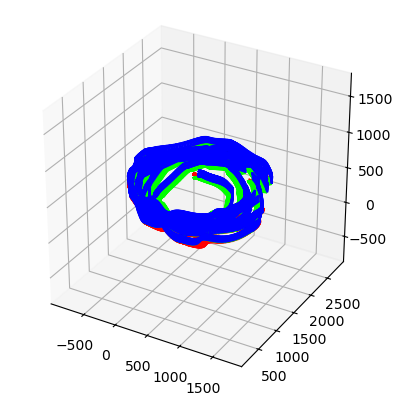

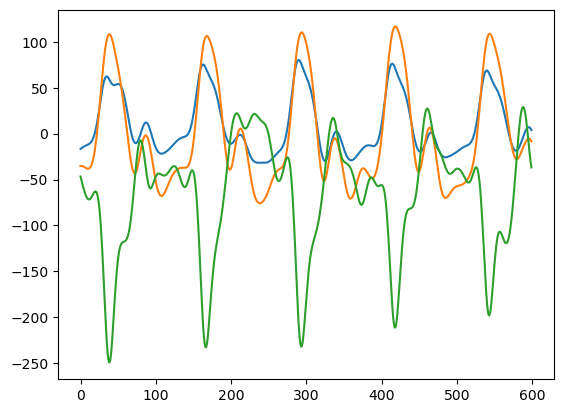

In [33]:
%matplotlib inline
plt.figure()
plt.plot(delta_euler_dgps[200:800, 0])
plt.plot(delta_euler_dgps[200:800, 1])
plt.plot(delta_euler_dgps[200:800, 2])
plt.show()

## 3) Encoder/goniometer features

In [23]:
dev_file = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Subject1/Session4_copy_Proc_GMC/Subj1 - Rec1 - Circular walking (diam 2m)(CW) - Rep1 - ModOut.csv"
df = pd.read_csv(dev_file)
joint_angle_arr = df[lat.COLS_JOINT_ANGLES].to_numpy()
print(np.shape(joint_angle_arr))

(5977, 18)


In [24]:
joint_vel_arr = np.diff(joint_angle_arr, axis=0) * 100
nan_row = np.zeros((1, np.shape(joint_angle_arr)[1]))
nan_row[:] = np.nan
joint_vel_arr = np.concatenate((joint_vel_arr, nan_row), axis=0)
print(np.shape(nan_row))
print(np.shape(joint_vel_arr))

(1, 18)
(5977, 18)


In [27]:
df_out = pd.DataFrame(joint_angle_arr, columns=lat.COLS_JOINT_ANGLE)
df_out[lat.COLS_JOINT_VELOCITY] = joint_vel_arr
print(df_out.columns)

Index(['LAnkleAngleX', 'LAnkleAngleY', 'LAnkleAngleZ', 'LKneeAngleX',
       'LKneeAngleY', 'LKneeAngleZ', 'LHipAngleX', 'LHipAngleY', 'LHipAngleZ',
       'RAnkleAngleX', 'RAnkleAngleY', 'RAnkleAngleZ', 'RKneeAngleX',
       'RKneeAngleY', 'RKneeAngleZ', 'RHipAngleX', 'RHipAngleY', 'RHipAngleZ',
       'LAnkleAngleDX', 'LAnkleAngleDY', 'LAnkleAngleDZ', 'LKneeAngleDX',
       'LKneeAngleDY', 'LKneeAngleDZ', 'LHipAngleDX', 'LHipAngleDY',
       'LHipAngleDZ', 'RAnkleAngleDX', 'RAnkleAngleDY', 'RAnkleAngleDZ',
       'RKneeAngleDX', 'RKneeAngleDY', 'RKneeAngleDZ', 'RHipAngleDX',
       'RHipAngleDY', 'RHipAngleDZ'],
      dtype='object')


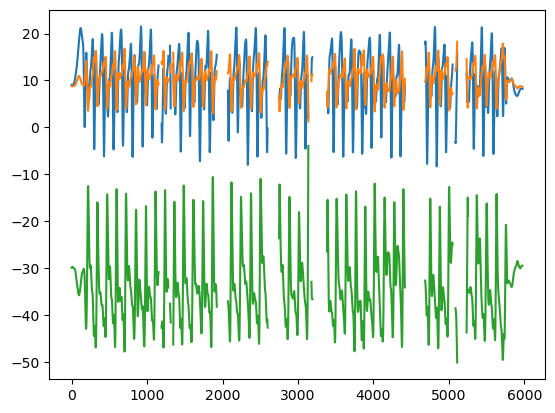

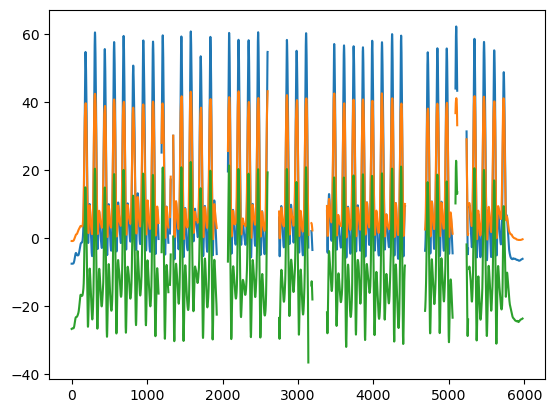

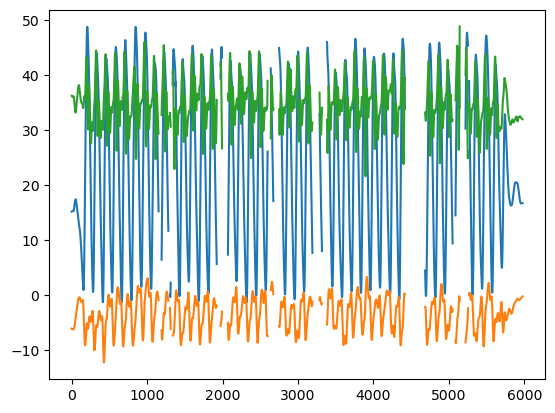

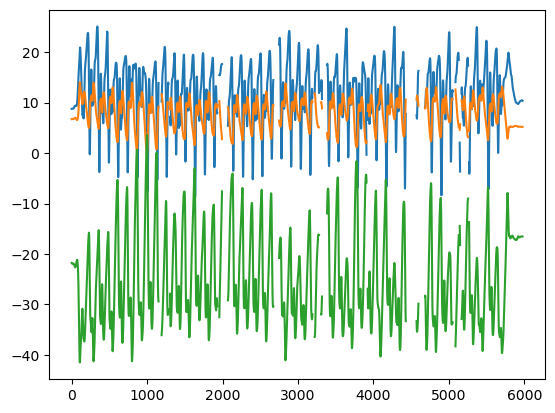

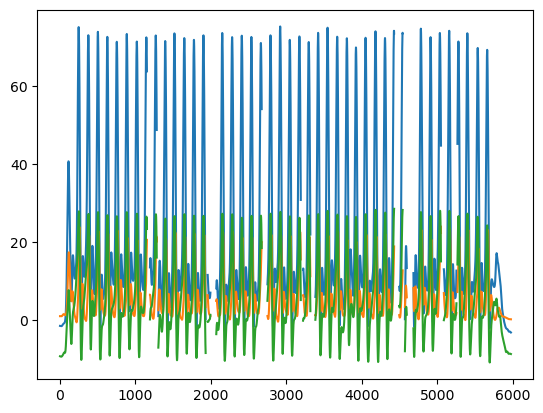

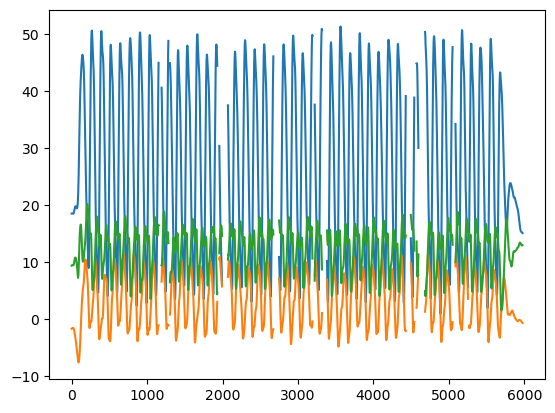

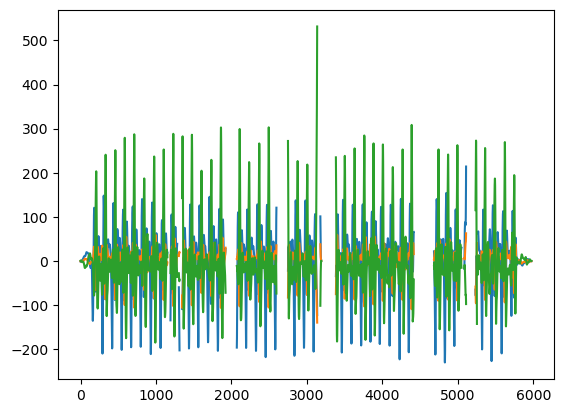

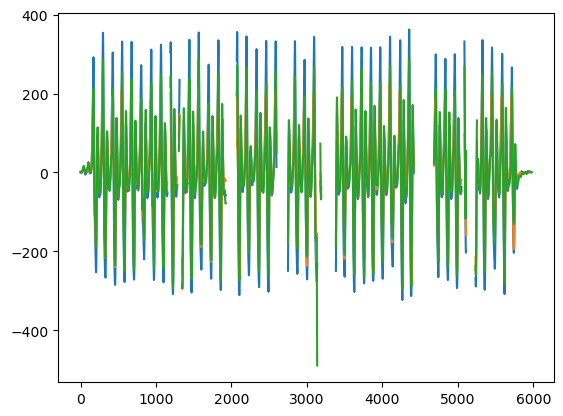

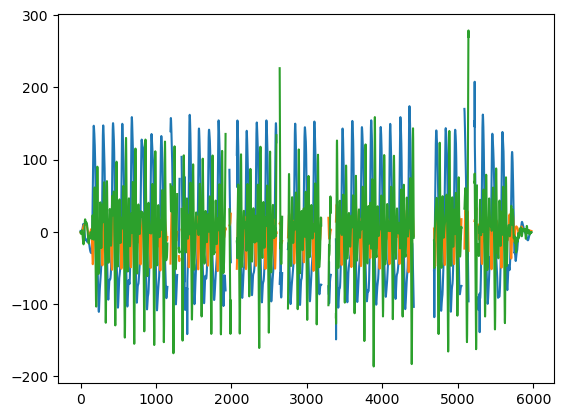

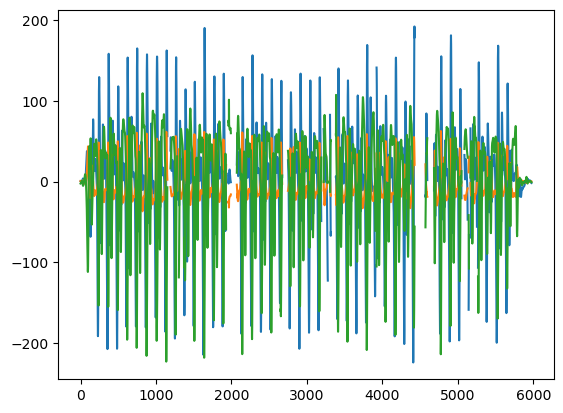

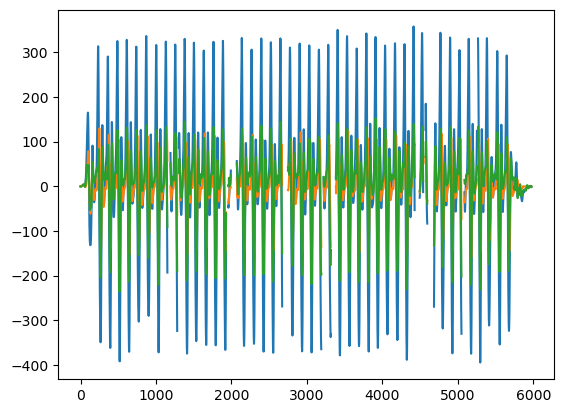

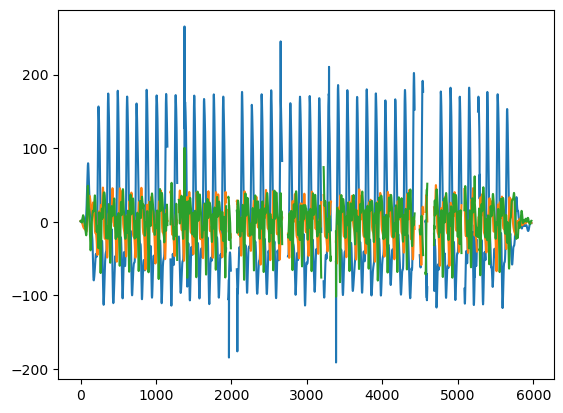

In [29]:
for i in np.arange(len(df_out.columns)/3):
    plt.figure()
    plt.plot(df_out[df_out.columns[int(3*i)]])
    plt.plot(df_out[df_out.columns[int(3*i+1)]])
    plt.plot(df_out[df_out.columns[int(3*i+2)]])
    plt.show()

## 4) Comparison of simulated IMU with moticon IMU data

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from scipy.signal import butter, sosfiltfilt
import LocomotionAnalysisTools as lat

In [2]:
def get_simulated_IMU_measurements(segment_orientation_position, f_sample=100, seq="XYZ"):    
    # Restructure
    rot_vecs = segment_orientation_position[:, 0:3] # in radians
    translations = segment_orientation_position[:, 3:6] # in meters

    # Change orientation representation, rotation vector to rotation matrices
    n_pts = np.shape(rot_vecs)[0]
    rot_matrices = np.zeros((n_pts, 3, 3))
    inv_rot_matrices = np.zeros((n_pts, 3, 3))

    for i in np.arange(n_pts):
        rotation = Rotation.from_rotvec(rot_vecs[i, :])
        rot_matrices[i, :, :] = rotation.as_matrix()
        inv_rot_matrices[i, :, :] = np.linalg.inv(rot_matrices[i, :, :])
        # inv_rot_matrices[i, :, :] = rotation.inv().as_matrix()

    # Calculate rotational velocity and linear acceleration a measured from the segment frame of reference
    delta_rot_matrices = np.zeros((n_pts-1, 3, 3))
    delta_euler_angles = np.zeros((n_pts-1, 3))

    accelerations = np.diff(translations, n=2, axis=0)
    accelerations *= f_sample**2
    
    gravity = np.concatenate((np.zeros((n_pts-2, 2)), np.ones((n_pts-2, 1))*9.81), axis=1)
    accelerations += gravity

    for i in np.arange(n_pts-2):
        delta_rot_matrices[i, :, :] = np.matmul(rot_matrices[i+1, :, :], inv_rot_matrices[i, :, :])
        rotation = Rotation.from_matrix(delta_rot_matrices[i, :, :])
        delta_euler_angles[i, :] = np.matmul(inv_rot_matrices[i, :, :], rotation.as_euler(seq).reshape((-1, 1))).reshape((1, -1))
        accelerations[i, :] = np.matmul(inv_rot_matrices[i, :, :], accelerations[i, :].reshape((-1, 1))).reshape((1, -1))

    i = n_pts-2
    delta_rot_matrices[i, :, :] = np.matmul(rot_matrices[i+1, :, :], inv_rot_matrices[i, :, :])
    rotation = Rotation.from_matrix(delta_rot_matrices[i, :, :])
    delta_euler_angles[i, :] = np.matmul(inv_rot_matrices[i, :, :], rotation.as_euler(seq).reshape((-1, 1))).reshape((1, -1))

    delta_euler_angles *= f_sample
    
    return delta_euler_angles, accelerations

In [3]:
# Simulated IMU features
dev_file = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Subject17/Session1_Proc_GMC/Subj17 - Rec1 - Circular walking (diam 2m)(CW) - Rep1 - GloAng.csv"
df = pd.read_csv(dev_file)

cols_R = ["R_Foot_RX", "R_Foot_RY", "R_Foot_RZ"]
cols_T = ["R_Foot_TX", "R_Foot_TY", "R_Foot_TZ"]
f_sample = 100
seq = "XYZ"

rot_vec = df[cols_R].to_numpy()
rot_vec = rot_vec * (np.pi/180) # to radians
translations = df[cols_T].to_numpy()
translations = translations * 0.001 # to meters

segment_orientation_position = np.concatenate((rot_vec, translations), axis=1)
delta_euler_angles, accelerations = get_simulated_IMU_measurements(segment_orientation_position, f_sample=f_sample, seq=seq)

# Reference IMU features
ref_file = "C:/Users/robaeten/OneDrive - UGent/Gait Classification and References/Data/Subject17/Session1_Proc_GMC/Subj17 - Rec1 - Circular walking (diam 2m)(CW) - Rep1 - MotNorm.csv"
df_ref = pd.read_csv(ref_file)
delta_euler_angles_ref = df_ref[["RANGX", "RANGY", "RANGZ"]].to_numpy()
accelerations_ref = df_ref[["RACCX", "RACCY", "RACCZ"]].to_numpy() * 9.81 # from g to m/s2

(1434, 3)
(1436, 3)
(1435, 3)
(1436, 3)


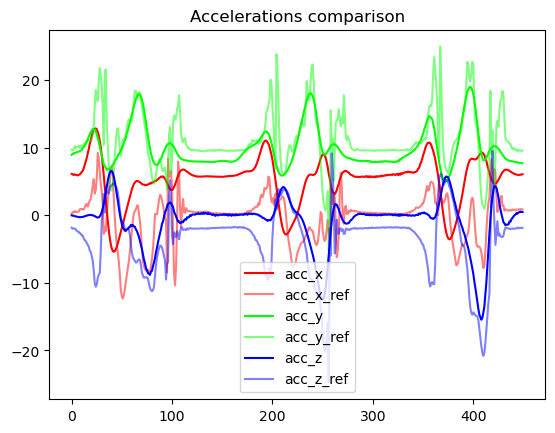

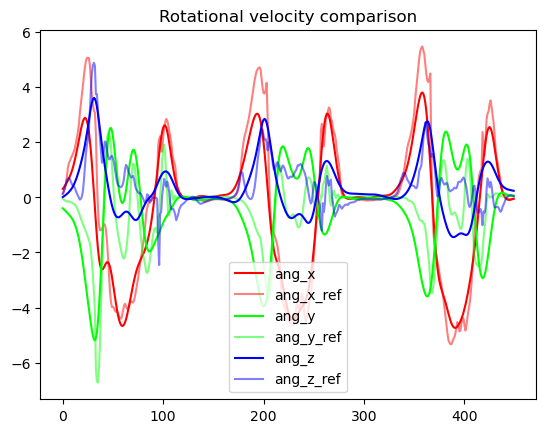

In [4]:
# Check sizes
print(np.shape(accelerations))
print(np.shape(accelerations_ref))
print(np.shape(delta_euler_angles))
print(np.shape(delta_euler_angles_ref))

# Visualize to compare
plt.figure()
plt.title("Accelerations comparison")
plt.plot(accelerations[800:1250, 0], label="acc_x", c=(1, 0, 0))
plt.plot(accelerations_ref[800:1250, 1], label="acc_x_ref", c=(1, 0, 0), alpha=0.5)
plt.plot(accelerations[800:1250, 1], label="acc_y", c=(0, 1, 0))
plt.plot(accelerations_ref[800:1250, 2], label="acc_y_ref", c=(0, 1, 0), alpha=0.5)
plt.plot(accelerations[800:1250, 2], label="acc_z", c=(0, 0, 1))
plt.plot(accelerations_ref[800:1250, 0], label="acc_z_ref", c=(0, 0, 1), alpha=0.5)
plt.legend()
plt.show()

plt.figure()
plt.title("Rotational velocity comparison")
plt.plot(delta_euler_angles[800:1250, 0], label="ang_x", c=(1, 0, 0))
plt.plot(delta_euler_angles_ref[800:1250, 1], label="ang_x_ref", c=(1, 0, 0), alpha=0.5)
plt.plot(delta_euler_angles[800:1250, 1], label="ang_y", c=(0, 1, 0))
plt.plot(delta_euler_angles_ref[800:1250, 2], label="ang_y_ref", c=(0, 1, 0), alpha=0.5)
plt.plot(delta_euler_angles[800:1250, 2], label="ang_z", c=(0, 0, 1))
plt.plot(delta_euler_angles_ref[800:1250, 0], label="ang_z_ref", c=(0, 0, 1), alpha=0.5)
plt.legend()
plt.show()

In [33]:
R2_ang = np.corrcoef(accelerations[800:1250, :], y=accelerations_ref[800:1250, :], rowvar=False)
print(R2_ang[0, 4], R2_ang[1, 5], R2_ang[2, 3])

ref_filtered = accelerations_ref[800:1250, :]
filter = butter(2, 6, btype='low', analog=False, output='sos', fs=f_sample)
ref_filtered_acc = sosfiltfilt(filter, ref_filtered, axis=0)
R2_ang = np.corrcoef(accelerations[800:1250, :], y=ref_filtered, rowvar=False)
print(R2_ang[0, 4], R2_ang[1, 5], R2_ang[2, 3])

# plt.figure()
# plt.title("Accelerations comparison")
# plt.plot(accelerations[800:1250, 0], label="acc_x", c=(1, 0, 0))
# plt.plot(ref_filtered_acc[:, 1], label="acc_x_ref", c=(1, 0, 0), alpha=0.5)
# plt.plot(accelerations[800:1250, 1], label="acc_y", c=(0, 1, 0))
# plt.plot(ref_filtered_acc[:, 2], label="acc_y_ref", c=(0, 1, 0), alpha=0.5)
# plt.plot(accelerations[800:1250, 2], label="acc_z", c=(0, 0, 1))
# plt.plot(ref_filtered_acc[:, 0], label="acc_z_ref", c=(0, 0, 1), alpha=0.5)
# plt.legend()
# plt.show()

R2_ang = np.corrcoef(delta_euler_angles[800:1250, :], y=delta_euler_angles_ref[800:1250, :], rowvar=False)
print(R2_ang[0, 4], R2_ang[1, 5], R2_ang[2, 3])

ref_filtered = delta_euler_angles_ref[800:1250, :]
filter = butter(2, 6, btype='low', analog=False, output='sos', fs=f_sample)
ref_filtered_ang = sosfiltfilt(filter, ref_filtered, axis=0)
R2_ang = np.corrcoef(delta_euler_angles[800:1250, :], y=ref_filtered, rowvar=False)
print(R2_ang[0, 4], R2_ang[1, 5], R2_ang[2, 3])

# plt.figure()
# plt.title("Rotational velocity comparison")
# plt.plot(delta_euler_angles[800:1250, 0], label="ang_x", c=(0.7, 0.1, 0.1))
# plt.plot(ref_filtered_ang[:, 1], label="ang_x_ref", c=(0.7, 0.1, 0.1), alpha=0.5)
# plt.plot(delta_euler_angles[800:1250, 1], label="ang_y", c=(0.1, 0.7, 0.1))
# plt.plot(ref_filtered_ang[:, 2], label="ang_y_ref", c=(0.1, 0.7, 0.1), alpha=0.5)
# plt.plot(delta_euler_angles[800:1250, 2], label="ang_z", c=(0.1, 0.1, 0.7))
# plt.plot(ref_filtered_ang[:, 0], label="ang_z_ref", c=(0.1, 0.1, 0.7), alpha=0.5)
# plt.legend()
# plt.show()


%matplotlib qt

### Define style
title_size = 50
title_weight = "bold"
titlepad = 50

ylabel_size = 35
ylabel_weight = "normal"
ylabelpad_1 = 90
ylabelpad_2 = 90
ylabelpad_3 = 90
char_comp = -12

xlabel_size = 35
xlabel_weight = "normal"
xlabelpad = 25

tick_size = 20

linestyle = "-"
linewidth = 4
linestyle_ref = "--"
linewidth_ref = 4

legend_size = 20

def set_font_size_ticks(axs, size):
    xticks = axs.get_xticks()
    xticks[0] = -0.3
    xticks[-1] = 4.8
    xticklabels = axs.get_xticklabels()
    xticklabels[0] = None
    xticklabels[-1] = None
    yticks = axs.get_yticks()
    yticklabels = axs.get_yticklabels()
    axs.set_xticks(xticks, labels=xticklabels, size=size)
    axs.set_yticks(yticks, labels=yticklabels, size=size)
    return

def get_nchar_yticks(axs):
    yticklabels = axs.get_yticklabels()
    nchar = 0
    for label in yticklabels:
        nchar_i = len(label.get_text())
        if nchar_i > nchar:
            nchar = nchar_i
        else:
            pass
    return nchar

fig, axs = plt.subplots(3, 2, figsize=(12, 9))
x_axis = np.linspace(0, 4.5, num=450)

# Accelerations
axs[0, 0].yaxis.tick_left()
axs[0, 0].yaxis.set_label_position("left")
axs[1, 0].yaxis.tick_left()
axs[1, 0].yaxis.set_label_position("left")
axs[2, 0].yaxis.tick_left()
axs[2, 0].yaxis.set_label_position("left")

axs[0, 0].plot(x_axis, accelerations[800:1250, 0], label="acc_x", c=(0.7, 0.1, 0.1), linestyle=linestyle, linewidth=linewidth)
axs[1, 0].plot(x_axis, accelerations[800:1250, 1], label="acc_y", c=(0.1, 0.7, 0.1), linestyle=linestyle, linewidth=linewidth)
axs[2, 0].plot(x_axis, accelerations[800:1250, 2], label="acc_z", c=(0.1, 0.1, 0.7), linestyle=linestyle, linewidth=linewidth)
axs[0, 0].plot(x_axis, ref_filtered_acc[:, 1], label="acc_x_ref", c=(0.7, 0.1, 0.1), alpha=0.5, linestyle=linestyle_ref, linewidth=linewidth_ref)
axs[1, 0].plot(x_axis, ref_filtered_acc[:, 2], label="acc_y_ref", c=(0.1, 0.7, 0.1), alpha=0.5, linestyle=linestyle_ref, linewidth=linewidth_ref)
axs[2, 0].plot(x_axis, ref_filtered_acc[:, 0], label="acc_z_ref", c=(0.1, 0.1, 0.7), alpha=0.5, linestyle=linestyle_ref, linewidth=linewidth_ref)

# Angular velocities
axs[0, 1].yaxis.tick_right()
axs[0, 1].yaxis.set_label_position("right")
axs[1, 1].yaxis.tick_right()
axs[1, 1].yaxis.set_label_position("right")
axs[2, 1].yaxis.tick_right()
axs[2, 1].yaxis.set_label_position("right")

axs[0, 1].plot(x_axis, delta_euler_angles[800:1250, 0], label="ang_x", c=(0.7, 0.1, 0.1), linestyle=linestyle, linewidth=linewidth)
axs[1, 1].plot(x_axis, delta_euler_angles[800:1250, 1], label="ang_y", c=(0.1, 0.7, 0.1), linestyle=linestyle, linewidth=linewidth)
axs[2, 1].plot(x_axis, delta_euler_angles[800:1250, 2], label="ang_z", c=(0.1, 0.1, 0.7), linestyle=linestyle, linewidth=linewidth)
axs[0, 1].plot(x_axis, ref_filtered_ang[:, 1], label="ang_x_ref", c=(0.7, 0.1, 0.1), alpha=0.5, linestyle=linestyle_ref, linewidth=linewidth_ref)
axs[1, 1].plot(x_axis, ref_filtered_ang[:, 2], label="ang_y_ref", c=(0.1, 0.7, 0.1), alpha=0.5, linestyle=linestyle_ref, linewidth=linewidth_ref)
axs[2, 1].plot(x_axis, ref_filtered_ang[:, 0], label="ang_z_ref", c=(0.1, 0.1, 0.7), alpha=0.5, linestyle=linestyle_ref, linewidth=linewidth_ref)


### Set labels and stuff
# Accelerations
axs[0, 0].set_title("Linear accelerations", size=title_size, weight=title_weight, pad=titlepad)
axs[0, 0].set_ylabel("Along x-axis [m/s2]", size=ylabel_size, weight=ylabel_weight, 
                     labelpad=(ylabelpad_1+char_comp*get_nchar_yticks(axs[0, 0])))
set_font_size_ticks(axs[0, 0], tick_size)
axs[0, 0].legend(fontsize=legend_size, loc="lower left")
axs[0, 0].grid()

axs[1, 0].set_ylabel("Along y-axis [m/s2]", size=ylabel_size, weight=ylabel_weight, 
                     labelpad=(ylabelpad_1+char_comp*get_nchar_yticks(axs[1, 0])))
set_font_size_ticks(axs[1, 0], tick_size)
axs[1, 0].legend(fontsize=legend_size, loc="lower left")
axs[1, 0].grid()

axs[2, 0].set_ylabel("Along z-axis [m/s2]", size=ylabel_size, weight=ylabel_weight, 
                     labelpad=(ylabelpad_1+char_comp*get_nchar_yticks(axs[2, 0])))
set_font_size_ticks(axs[2, 0], tick_size)
axs[2, 0].legend(fontsize=legend_size, loc="lower left")
axs[2, 0].grid()

# Angular velocities
axs[0, 1].set_title("Angular velocities", size=title_size, weight=title_weight, pad=titlepad)
axs[0, 1].set_ylabel("Around x-axis [rad/s]", size=ylabel_size, weight=ylabel_weight, 
                     labelpad=(ylabelpad_1+char_comp*get_nchar_yticks(axs[0, 1])))
set_font_size_ticks(axs[0, 1], tick_size)
axs[0, 1].legend(fontsize=legend_size, loc="upper right")
axs[0, 1].grid()

axs[1, 1].set_ylabel("Around y-axis [rad/s]", size=ylabel_size, weight=ylabel_weight, 
                     labelpad=(ylabelpad_1+char_comp*get_nchar_yticks(axs[1, 1])))
set_font_size_ticks(axs[1, 1], tick_size)
axs[1, 1].legend(fontsize=legend_size, loc="upper right")
axs[1, 1].grid()

axs[2, 1].set_ylabel("Around z-axis [rad/s]", size=ylabel_size, weight=ylabel_weight, 
                     labelpad=(ylabelpad_1+char_comp*get_nchar_yticks(axs[2, 1])))
set_font_size_ticks(axs[2, 1], tick_size)
axs[2, 1].legend(fontsize=legend_size, loc="upper right")
axs[2, 1].grid()


### Done!
plt.show()

0.34917165931727345 0.574848303964138 0.8626902167261018
0.34917165931727345 0.574848303964138 0.8626902167261018
0.9652332291477504 0.6794417852511184 0.5414663653723101
0.9652332291477504 0.6794417852511184 0.5414663653723101
